In [ ]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
%env CUDA_VISIBLE_DEVICES=2
%cd ..

In [2]:
from typing import Iterable
import json
from pathlib import Path
from copy import deepcopy
from itertools import product
from multiprocessing import Pool, cpu_count

import numpy as np
import cv2

from matplotlib import pyplot as plt, colormaps as cm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import functional as VF, InterpolationMode

from tqdm import tqdm

from transformers import SegformerForSemanticSegmentation, SegformerConfig

images_dir = Path("data/dataset_crop")
labels_path = Path("data/result.json")

In [3]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

In [4]:
with open(labels_path, "r") as f:
    seg_labels = json.load(f)

for i in range(len(seg_labels["images"])):
    name = seg_labels["images"][i]["file_name"]
    name = images_dir / name.split("__")[-1]
    seg_labels["images"][i]["file_name"] = name

In [5]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        labels: dict,
        prune_empty: bool = True,
        image_transform: nn.Module = None,
        mask_transform: nn.Module = None,
    ):
        self.labels = labels
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        for img in labels["images"]:
            assert Path(img["file_name"]).exists()

        images = [None] * len(self.labels["images"])
        annotations = [[] for _ in range(len(self.labels["images"]))]

        for image in labels["images"]:
            images[image["id"]] = image["file_name"]

        for annotation in labels["annotations"]:
            annotations[annotation["image_id"]].append(
                {
                    "poly": np.array(
                        annotation["segmentation"], dtype=np.int32
                    ).reshape(-1, 2),
                    "category": annotation["category_id"] + 1,
                }
            )

        self.images = images
        self.annotations = annotations

        if prune_empty:
            ids = [i for i in range(len(self.labels["images"])) if annotations[i]]
            self.images = [self.images[i] for i in ids]
            self.annotations = [self.annotations[i] for i in ids]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        image = read_image(self.images[idx]) / 255.0
        mask = np.zeros(list(image.shape[1:]), dtype=np.uint8)

        for annotation in self.annotations[idx]:
            mask = cv2.fillPoly(
                mask,
                [annotation["poly"]],
                # color=annotation["category"],
                color=1,
            )
        mask = torch.tensor(mask, dtype=torch.uint8)[None]

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image.contiguous(), mask.squeeze(0).contiguous()


transform_image = transforms.Compose(
    [
        transforms.Resize((512, 512), interpolation=InterpolationMode.BICUBIC),
    ]
)

transform_mask = transforms.Compose(
    [
        transforms.Resize((512, 512), interpolation=InterpolationMode.NEAREST),
        transforms.Lambda(lambda x: x.long()),
    ]
)

In [6]:
dataset = SegmentationDataset(
    seg_labels, image_transform=transform_image, mask_transform=transform_mask
)
print(f"total number of images: {len(dataset)}")

train_dataset, val_dataset = random_split(
    dataset,
    [0.75, 0.25],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8)

total number of images: 160


In [ ]:
class SegformerWrapper(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def _upscale_logits(self, logits: torch.Tensor, target_shape: tuple = (512, 512)):
        logits = VF.resize(
            logits,
            size=target_shape,
            interpolation=InterpolationMode.BILINEAR,
        )
        return logits

    def forward(self, images: torch.Tensor):
        logits = self.model(images).logits
        logits = self._upscale_logits(logits, target_shape=images.shape[2:])
        return logits


model_name = "nvidia/segformer-b2-finetuned-ade-512-512"


config = SegformerConfig.from_pretrained(model_name)
config.num_labels = 1

base_model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True,
    weights_only=False,
)

model = SegformerWrapper(base_model)

In [8]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor, eps=1e-6):
    """
    logits: [B, C, H, W] raw scores
    labels: [B, H, W] ints in [0..C-1]
    """
    # convert to one-hot: [B, C, H, W]
    num_classes = logits.shape[1]
    labels_onehot = F.one_hot(labels, num_classes).permute(0, 3, 1, 2).float()
    probs = F.softmax(logits, dim=1)
    # compute per-class dice
    intersection = torch.sum(probs * labels_onehot, dim=(2, 3))
    union = torch.sum(probs + labels_onehot, dim=(2, 3))
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()


def binary_dice_loss(probs: torch.Tensor, labels: torch.Tensor, eps=1e-6):
    """
    logits: [B, C, H, W] raw scores
    labels: [B, H, W] ints in [0..C-1]
    """
    # convert to one-hot: [B, C, H, W]
    # compute per-class dice
    labels = labels.to(probs.dtype)
    intersection = torch.sum(probs * labels, dim=(1, 2))
    union = torch.sum(probs + labels, dim=(1, 2))
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()


def ce_loss(logits: torch.Tensor, labels: torch.Tensor, weight: torch.Tensor | None):
    """
    logits: [B, C, H, W] raw scores
    labels: [B, H, W] ints in [0..C-1]
    """
    return F.cross_entropy(logits, labels, weight=weight)


def binary_focal_loss(probs: torch.Tensor, labels: torch.Tensor, gamma: float = 2.0):
    """
    logits: [B, C, H, W] raw scores
    labels: [B, H, W] ints in [0..C-1]
    """
    return torch.mean(
        -(labels * torch.log(probs) * (1 - probs) ** gamma)
        - ((1 - labels) * torch.log(1 - probs) * (probs) ** gamma)
    )


class SegformerLoss(nn.Module):
    def __init__(
        self,
        ce_weight: float = 1,
        dice_weight: float = 1,
        class_weights: torch.Tensor | None = None,
    ):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.class_weights = class_weights

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        ce = ce_loss(logits, labels, weight=self.class_weights)
        dice = dice_loss(logits, labels)
        return self.ce_weight * ce + self.dice_weight * dice


class BinarySegformerLoss(nn.Module):
    def __init__(self, focal_weight: float = 1, dice_weight: float = 1):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        probs = F.sigmoid(logits.squeeze(1))
        focal = binary_focal_loss(probs, labels)
        dice = binary_dice_loss(probs, labels)
        return self.focal_weight * focal + self.dice_weight * dice


def iou(
    logits: torch.Tensor,
    labels: torch.Tensor,
    threshold: float = 0.5,
    eps: float = 1e-6,
) -> torch.Tensor:
    preds_bin = F.sigmoid(logits) > threshold
    labels_bin = labels > 0.5

    intersection = torch.sum(preds_bin & labels_bin, dim=(-2, -1)) + eps
    union = torch.sum(preds_bin | labels_bin, dim=(-2, -1)) + eps

    return intersection / union

In [9]:
def train_fn(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: str,
    n_epochs: int = 5,
):
    model.to(device)
    best_val_metric = -torch.inf
    best_model = deepcopy(model).cpu()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.1,
        patience=3,
    )
    # loss_fn = SegformerLoss(
    #     ce_weight=1,
    #     dice_weight=1,
    #     class_weights=torch.tensor([1.0, 5.0, 5.0, 5.0, 5.0, 5.0], device=device),
    # )
    loss_fn = BinarySegformerLoss()

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0
        train_loop = tqdm(train_loader, desc=f"[{epoch}/{n_epochs}] Train Epoch")

        for i, (x, y) in enumerate(train_loop):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            preds_raw = model(x)
            loss = loss_fn(preds_raw, y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            train_loop.set_postfix(loss=running_loss / (i + 1))

        model.eval()
        ious = []
        eval_loop = tqdm(val_loader, desc=f"[{epoch}/{n_epochs}] Evaluation Epoch")

        with torch.no_grad():
            for i, (x, y) in enumerate(eval_loop):
                x = x.to(device)
                y = y.to(device)

                preds_raw = model(x).squeeze(1)
                ious.extend(iou(preds_raw, y).cpu().tolist())

                eval_loop.set_postfix(iou=np.mean(ious), best_iou=best_val_metric)

        val_metric = np.mean(ious)
        # scheduler.step(metrics=val_metric)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_model = deepcopy(model).cpu()

    return best_model, val_metric

In [10]:
def get_num_params(model: nn.Module):
    return sum(param.numel() for param in model.parameters())


print(f"number of model parameters: {get_num_params(model)}")

number of model parameters: 27347393


In [11]:
# model, val_metric = train_fn(
#     model,
#     train_loader,
#     val_loader,
#     get_device(),
#     n_epochs=100,
# )
# model.cpu()
# torch.save(model.state_dict(), f"checkpoints/spike_counter_{val_metric:.4f}.pt")

In [12]:
# model.load_state_dict(torch.load(f"checkpoints/spike_counter_{val_metric:.4f}.pt", weights_only=True))
model.load_state_dict(
    torch.load("checkpoints/spike_counter_0.0000.pt", weights_only=True)
)
model.half()

SegformerWrapper(
  (model): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (l

In [14]:
model.eval()
model.cuda()
img, gt_mask = val_dataset[0]

with torch.no_grad():
    pred = model(img[None].to(torch.float16).cuda())[0].cpu()
# pred[:, 1:] *= 5
# pred_mask = torch.argmax(pred.cpu().squeeze(), dim=0).numpy()
pred_mask = (F.sigmoid(pred) > 0.5).to(torch.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


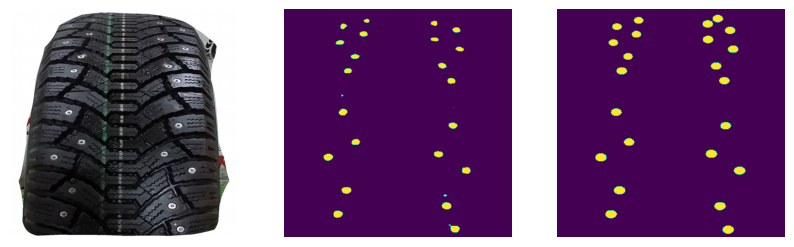

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 10))

axes[0].imshow(img.permute(1, 2, 0))
# cmap = cm.get_cmap("hsv")
# pred_mask = np.where(pred_mask[..., None] != 0, cmap(pred_mask / 6)[..., 1:], 0)
axes[1].imshow(pred_mask[0])
axes[2].imshow(gt_mask)

for ax in axes:
    ax.axis("off")

plt.show()

In [14]:
numpy_mask = pred_mask.numpy()[0].astype(np.uint8)

kernel = np.ones((3, 3), dtype=np.uint8)

numpy_mask = cv2.erode(numpy_mask, kernel, iterations=2)
numpy_mask = cv2.dilate(numpy_mask, kernel, iterations=2)

num_labels, labels, stats, centroids_preds = cv2.connectedComponentsWithStats(
    numpy_mask, connectivity=8, ltype=cv2.CV_32S
)

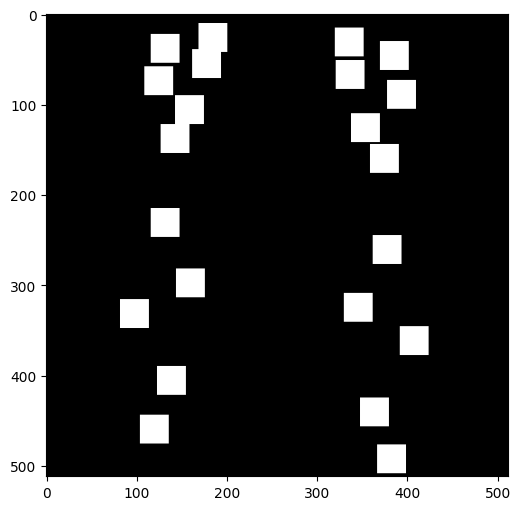

In [22]:
cubes = np.zeros_like(numpy_mask)
for i in range(1, num_labels):  # skip background row 0
    x, y, w, h, area = stats[i]
    x1, y1 = x, y
    x2, y2 = x + w, y + h
    c1, c2 = x + w // 2, y + h // 2
    c1, c2 = centroids_preds[i].astype(np.int32)
    # fill the box
    cubes[c2 - 16 : c2 + 16, c1 - 16 : c1 + 16] = 255

plt.figure(figsize=(6, 6))
plt.imshow(cubes, cmap="gray")

In [16]:
@torch.no_grad()
def get_model_preds(
    model: nn.Module, images: Iterable[torch.Tensor], device: str = "cuda"
):
    result = []

    model.eval()
    model.to(device)

    for image in images:
        image = image.to(device)
        orig_size = list(image.shape[-2:])

        image_resized = VF.resize(
            image, [512, 512], interpolation=InterpolationMode.BICUBIC
        ).clamp(0, 1)
        logits = model(image_resized[None])
        logits = VF.resize(logits, orig_size, interpolation=InterpolationMode.BICUBIC)

        probs = F.sigmoid(logits).squeeze().cpu()

        result.append(probs)

    return result


def evaluate_model(
    model_preds: Iterable[torch.Tensor],
    masks: Iterable[torch.Tensor],
    threshold: float = 0.5,
    n_erosion_iterations: int = 3,
    n_dilation_iterations: int = 3,
    window_size: int = 21,
):
    result = {
        "correct": [],
        "incorrect": [],
        "miss": [],
        "ambiguous": [],
        "errors": [],
    }

    r = window_size // 2
    kernel = np.ones(shape=(3, 3), dtype=np.uint8)

    for probs, mask in zip(model_preds, masks):
        correct_count = 0
        incorrect_count = 0
        ambiguous_count = 0

        preds_bin = (probs > threshold).to(torch.uint8).numpy()

        preds_bin = cv2.erode(preds_bin, kernel, iterations=n_erosion_iterations)
        preds_bin = cv2.dilate(preds_bin, kernel, iterations=n_dilation_iterations)

        mask_numpy = mask.to(torch.uint8).numpy()

        _, _, _, centroids_preds = cv2.connectedComponentsWithStats(
            preds_bin, connectivity=8, ltype=cv2.CV_32S
        )
        _, _, _, centroids_gt = cv2.connectedComponentsWithStats(
            mask_numpy, connectivity=8, ltype=cv2.CV_32S
        )

        centroids_preds = centroids_preds.astype(np.int32)[1:]
        centroids_gt = centroids_gt.astype(np.int32)[1:]
        centroids_gt_accounted = np.zeros(centroids_gt.shape[0])

        for c1, c2 in centroids_preds:
            mask = np.zeros(centroids_gt.shape, dtype=bool)
            mask[:, 0][
                np.where(
                    (centroids_gt[:, 0] >= c1 - r) & (centroids_gt[:, 0] <= c1 + r)
                )
            ] = True
            mask[:, 1][
                np.where(
                    (centroids_gt[:, 1] >= c2 - r) & (centroids_gt[:, 1] <= c2 + r)
                )
            ] = True

            mask = np.all(mask, axis=1)

            num_detections = mask.sum()

            if num_detections > 1:
                ambiguous_count += num_detections - 1
                continue

            if num_detections < 1:
                incorrect_count += 1
                continue

            centroids_gt_accounted[mask] += 1
            correct_count += 1

        miss_count = np.sum(centroids_gt_accounted == 0)
        penalty = np.sum(np.clip(centroids_gt_accounted - 1, a_min=0, a_max=None))
        correct_count -= penalty
        ambiguous_count += penalty

        result["correct"].append(correct_count)
        result["incorrect"].append(incorrect_count)
        result["miss"].append(miss_count)
        result["ambiguous"].append(ambiguous_count)
        result["errors"].append(abs(len(centroids_preds) - len(centroids_gt)))

    return result

In [17]:
test_dataset = SegmentationDataset(seg_labels)
images = []
masks = []
for idx in val_dataset.indices:
    image, mask = test_dataset[idx]
    images.append(image)
    masks.append(mask)

model_preds = get_model_preds(model, images)

In [21]:
eval_results = evaluate_model(
    model_preds,
    masks,
    threshold=0.2,
    n_erosion_iterations=0,
    n_dilation_iterations=0,
    window_size=32,
)
print(
    f"Correct detections: {np.mean(eval_results['correct']):.4f} (std={np.std(eval_results['correct']):.4f})"
)
print(
    f"Incorrect detections: {np.mean(eval_results['incorrect']):.4f} (std={np.std(eval_results['incorrect']):.4f})"
)
print(
    f"Miss detections: {np.mean(eval_results['miss']):.4f} (std={np.std(eval_results['miss']):.4f})"
)
print(
    f"Ambiguous detections: {np.mean(eval_results['ambiguous']):.4f} (std={np.std(eval_results['ambiguous']):.4f})"
)
print(
    f"Errors: {np.mean(eval_results['errors']):.4f} (std={np.std(eval_results['errors']):.4f})"
)

Correct detections: 20.9500 (std=9.6124)
Incorrect detections: 4.3750 (std=7.3508)
Miss detections: 3.6250 (std=4.3456)
Ambiguous detections: 0.0000 (std=0.0000)
Errors: 5.1500 (std=6.3543)
